# Distributed Optimization with the Alternating Direction Method of Multipliers

In this lecture we will see the how the ADMM algorithm can be used for distributed optimization. Using the notatation from the course slides, we aim to solve the following optimization problem

![](ADMM_problem.png)


The algorithm is described by the following iteration:

![](ADMM_algorithm.png)

where the first N updates can be done in parallel.

## References

* [DSOML course notes](http://marcocuturi.net/Teaching/ENSAE/2017/DSOML/DSOML5.pdf)

* [Distributed Optimization and Statistical
Learning via the Alternating Direction
Method of Multipliers](http://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf), S. Boyd et al. 2010

In [1]:
# .. needed imports ..
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib




# Practical session: Lasso problem

We will now use ADMM to solve a nonsmooth optimization problem.


The Lasso is staistical model that has found many applications in machine learning, signal processing, biomedical imaging and genetics, to name a few. Given a regression dataset $A \in \mathbb{R}^{n \times p}, b \in \mathbb{R}^n$, the Lasso is determined as the solution to the optimization problem

$$\text{argmin}_{\theta} \frac{1}{2}\|A \theta - b\|^2 + \lambda \|\theta\|_1 \quad,$$
where $\lambda$ is a regularization parameter. The Lasso model is so useful because, given enough regularization, it gives solutions which are *sparse*, i.e., with many zero coefficients.

Structure of this session:

   * I will implement a version of ADMM with 1 split.
   * You will implement the algorithm with more than 2 splits.
   * We will parallelize the splitting algorithm in Python using multiprocessing.
   * We will see one application of the lasso, that of tomography reconstruction. 

![](tomography.png)

## Take 1: a simple implementation

We can reformulate the Lasso problem in the following equivalent form
$$
\begin{aligned}
&\text{argmin}_{\theta} \frac{1}{2}\|A \theta - b\|^2 + \lambda \|\rho\|_1 \quad,\\
&\text{ subject to }~ \theta=\rho
\end{aligned}
$$

Now that we have written it in ADMM-friendly fashion, we can use the the above algorithm with $N=1$. This gives the following iteration:
$$
\begin{aligned}
&\theta^{t+1} = \text{argmin}_{\theta} \frac{1}{2}\|A \theta - b\|^2 + \frac{\tau}{2}\|\theta - \rho^t - u^t\|^2 \\
&\rho^{t+1} = \text{argmin}_{\theta} \lambda \|\theta\|_1 + \frac{\tau}{2} \|\theta - \theta^{t+1} - u^t\|^2\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$

It turns that for this particular problem many of the steps have a closed form solution. Using this we have the following closed form updates:
$$
\begin{aligned}
&\theta^{t+1} = (A^T A + \tau I)^{-1}(A^T b + \tau (\rho^t - u^t)) \\
&\rho^{t+1} = (\theta^{t+1} + u^t - \frac{\tau}{\lambda})_+ - (\frac{\tau}{\lambda} - \theta^{t+1} - u^t)_+\\
& u^{t+1} = u^t + \theta^{t+1} - \rho^{t+1}
\end{aligned}
$$




In [39]:

# .. create some fake data ..
np.random.seed(0)

n_samples, n_features = 100, 100
A = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)

def obj_fun(theta, lamb):
    # .. the lasso objective function ..
    return 0.5 * np.sum(np.linalg.norm(A.dot(theta) - b)**2) + lamb * np.sum(np.abs(theta))

def lasso_ADMM(A, b, max_iter=10000, lamb=100.):
    # .. initialize variables ..
    tau = 1.
    rho = np.zeros(n_features)
    u = np.zeros(n_features)

    # .. to keep track of progress ..
    obj_fun_history = []

    # .. cache inverse matrix ..
    AtA_inv = np.linalg.pinv(A.T.dot(A) + tau * np.eye(n_features))
    for i in range(max_iter):
        theta = AtA_inv.dot(A.T.dot(b) + tau * (rho - u))
        rho = np.fmax(theta + u - lamb /tau, 0) - np.fmax(-lamb/tau - theta - u, 0)
        u = u + theta - rho
        obj_fun_history.append(obj_fun(theta, lamb))

    return theta, obj_fun_history
    
theta, func_vals = lasso_ADMM(A, b)

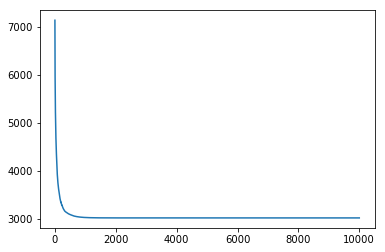

In [43]:
# lets plot the objective values of the function
# to make sure it has converged
plt.plot(func_vals)
plt.show()

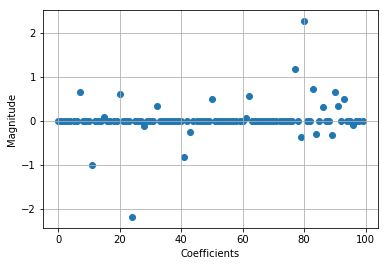

In [46]:
# let's also look at the coefficients of the solution
plt.scatter(np.arange(len(theta)), theta)
plt.ylabel('Magnitude')
plt.xlabel('Coefficients')
plt.grid()
plt.show()

They are **sparse**, i.e., with many coefficients set exactly to zero.

<span style="color: red; font-weight: bold">Exercise: logistic regression. what if the first step does not have a closed form solution?</span>

# Take 2: distributing computations

# Take 3: Logistic regression, a slightly more complex problem

## Compressive sensing application: tomography reconstruction with the Lasso

In [3]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36.
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return res - ndimage.binary_erosion(res)


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l / 7.)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

/Users/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fabian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:68: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


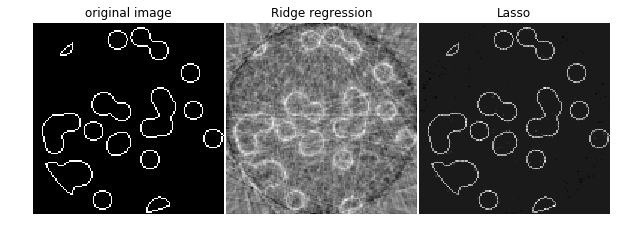

In [4]:

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Ridge regression')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Lasso')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()